#Preparación del entorno

Instalamos las librerias necesarias

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import zipfile
from prettytable import PrettyTable

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.base import RegressorMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Descargamos los archivos del dataset

In [23]:
!gdown --id $'1mfpXVLqDJah-sO0CF29LjKUz5NtKjZqc'
with zipfile.ZipFile('TP1-1-student_performance.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1mfpXVLqDJah-sO0CF29LjKUz5NtKjZqc
To: /content/TP1-1-student_performance.zip
100% 49.7k/49.7k [00:00<00:00, 76.7MB/s]


Habilitamos la GPU del entorno

In [24]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

1 Physical GPUs, 1 Logical GPUs


#Funciones de analisis de datos

Generamos unas funciones que nos permitan visualizar el comportamiento de los datos y las caracteristicas del dataframe

In [25]:
def analisis_dataframe(df: pd.DataFrame) -> None:
  """
  Realiza un análisis del DataFrame que incluye información básica,
  estadísticas descriptivas para columnas numéricas, valores únicos en
  columnas de tipo str y las primeras filas del DataFrame.
  """

  print("Información del DataFrame:\n")
  df.info()

  print("\n" + "-"*80 + "\n")

  print("Estadísticas de columnas numéricas:\n")
  print(df.describe())

  print("\n" + "-"*80 + "\n")

  str_columns = df.select_dtypes(include=['object']).columns
  for column in str_columns:
    unique_values = df[column].unique()
    print(f"Valores únicos en la columna '{column}': {unique_values}")

  print("\n" + "-"*80 + "\n")

  print("Primeras filas del DataFrame:\n")
  print(df.head())

def grafico_histogramas(df: pd.DataFrame, n_cols: int = 2, bins: int = 30) -> None:
  """
  Genera una matriz de histogramas para las variables numéricas en un
  DataFrame.

  Parameters:
  df (pandas.DataFrame): El DataFrame que contiene las variables para los
  histogramas.
  n_cols (int, optional): El número de columnas en la matriz de histogramas.
  Por defecto, es 2.
  bins (int, optional): El número de bins (contenedores) en cada histograma.
  Por defecto, es 30.
  """
  numeric_columns = df.select_dtypes(include=['number'])
  n = numeric_columns.shape[1]
  n_rows = (n + 1) // n_cols

  plt.figure(figsize=(12, 8))
  for i, column in enumerate(numeric_columns.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(data=numeric_columns, x=column, kde=True, bins=bins)
    plt.title(f'Histograma de {column}')

  plt.tight_layout()
  plt.show()

def grafico_dispercion(df: pd.DataFrame, etiquetas_columna: str = None) -> None:
  """
  Genera gráficos de dispersión para las variables de un DataFrame.

  Parameters:
  df (pandas.DataFrame): El DataFrame que contiene las variables para el
  gráfico de dispersión.

  etiquetas_columna (str, optional): El nombre de la columna con etiquetas.
  Si se proporciona, se utilizará para etiquetar los puntos en el gráfico.
  Por defecto, es None.

  Muestra un gráfico de dispersión para todas las variables en el DataFrame.
  Si se proporciona el nombre de la columna de etiquetas, los puntos se
  etiquetarán en el gráfico.

  """
  sns.set(style="ticks")
  if etiquetas_columna is not None and etiquetas_columna in df.columns:
    sns.pairplot(df, diag_kind="kde", hue=etiquetas_columna)
  else:
    sns.pairplot(df, diag_kind="kde")

  plt.subplots_adjust(top=0.95)
  plt.suptitle("Gráfico de Dispersión de Todas las Variables")
  plt.show()

def grafico_correlograma(df: pd.DataFrame):
  """
  Genera un correlograma para todas las variables numéricas en un DataFrame.

  Parameters:
  df (pandas.DataFrame): El DataFrame que contiene las variables para el correlograma.

  Returns:
  None

  Muestra un correlograma que incluye gráficos de dispersión y coeficientes de
  correlación para todas las variables numéricas en el DataFrame.
  """
  numeric_columns = df.select_dtypes(include=['float64', 'int64'])
  corr_matrix = numeric_columns.corr()

  plt.figure(figsize=(10, 8))
  sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
  plt.title("Correlograma de Variables Numéricas")
  plt.show()

#Carga de datos y visualización


Leemos los datos del archivo Student_Performance.csv

In [26]:
ruta_csv = 'Student_Performance.csv'
df = pd.read_csv(ruta_csv)

##Caracteristicas de los datos

In [27]:
analisis_dataframe(df)

Información del DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB

--------------------------------------------------------------------------------

Estadísticas de columnas numéricas:

       Hours Studied  Previous Scores   Sleep Hours  \
count   10000.000000     10000.000000  10000.000000   
mean        4.992900        69.445700      6.530600   
std         

El df no posee valores nulos por lo que no se realizará un tratamiento de valores faltantes.

Se observa que la unica columna no numerica es "Extracurricular Activities" que poseen valores de "Yes" y "No" por lo que debe tratarse posteriormente.

##Histogramas de las variables numericas

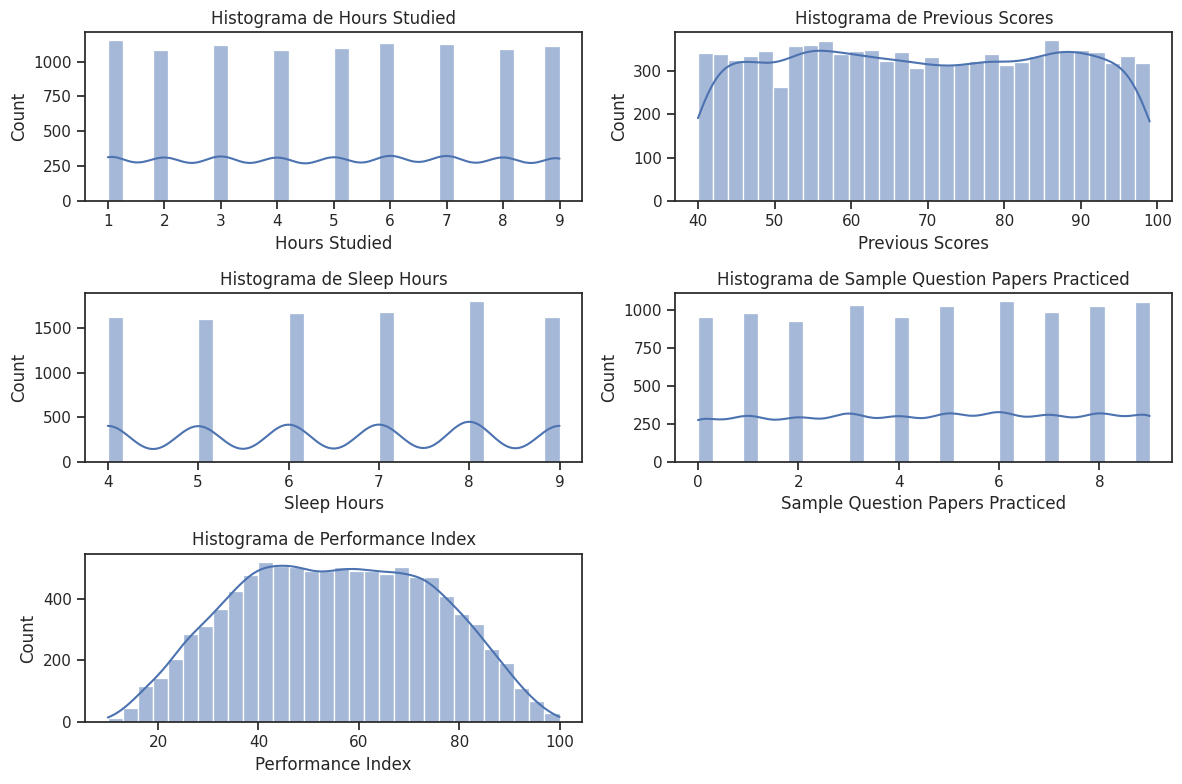

In [28]:
grafico_histogramas(df)

Observamos que los valores del "Performance index" posee una distribucion normal con media en 50 mientras que los demás parametros son constantes en su distribución.

##Graficos de dispersion

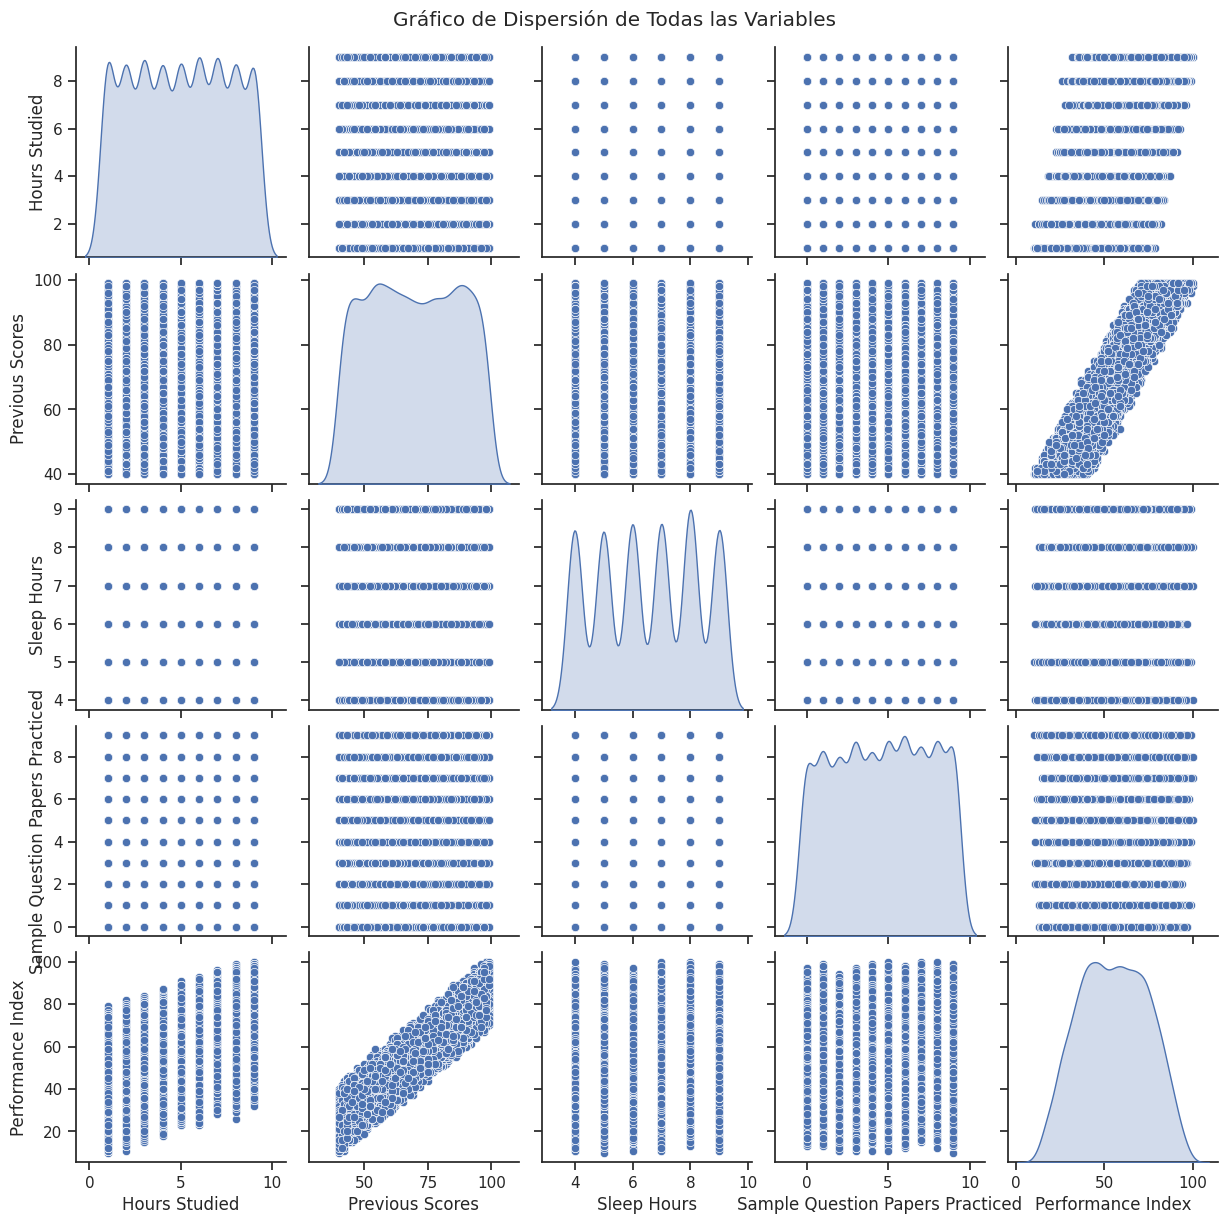

In [29]:
grafico_dispercion(df)

Se observa que las variables de "Performance Index" guarda relacion con "Hours Studied" y mas fuertemente con "Previous Scores".

## Correlograma

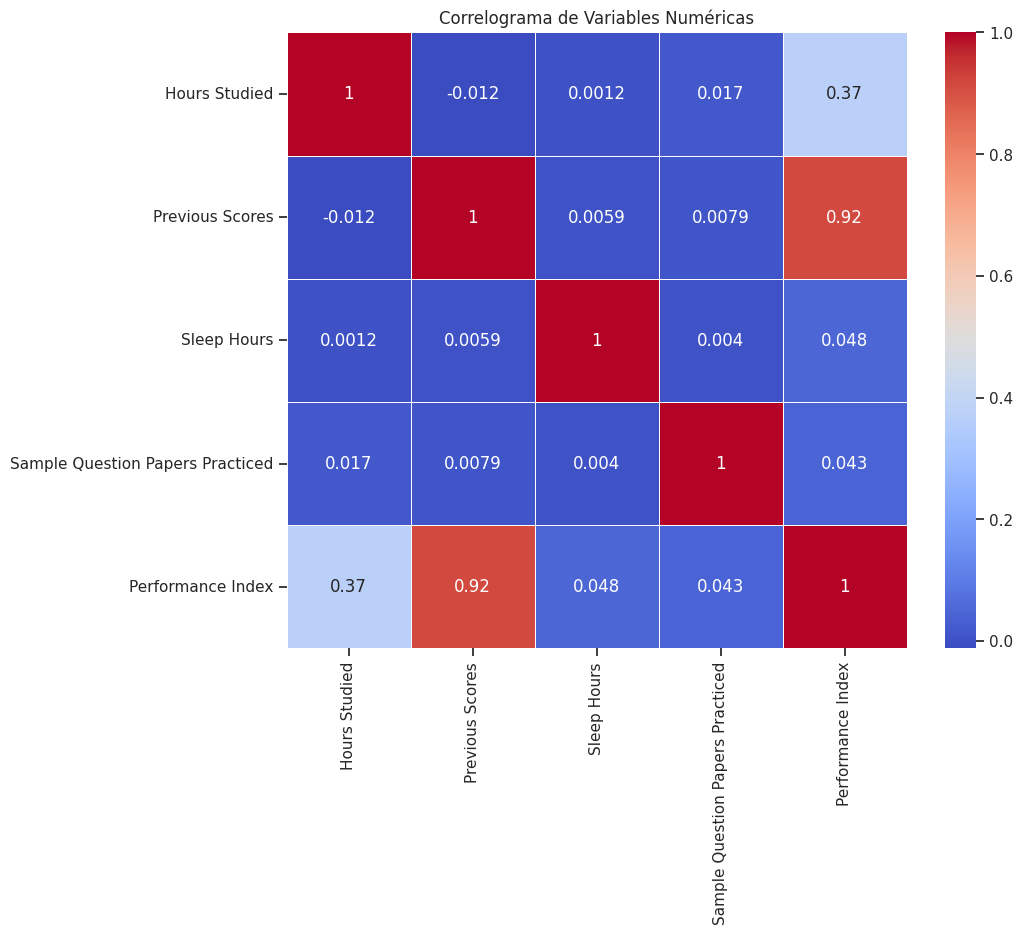

In [30]:
grafico_correlograma(df)

En general corroboramos lo observado en los graficos de dispersión, "Performance Index" tiene una relacion diractamente proporcional con "Hours Studied" y "Previous Score"

#Tratamiento de datos

Modificamos 'Extracurricular Activities' como una variable Dummy donde 'Yes' se reemplazará por 1 y 'No' por 0 para comprencion del modelo.

In [31]:
df['Extracurricular Activities'] = df['Extracurricular Activities'].replace({'Yes': 1, 'No': 0})

Segmentamos los datos y generamos dos escaladores para luego obtener los valores originales de las predicciones.

In [32]:
X = df.drop('Performance Index', axis=1)
y = df['Performance Index']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

#Modelo predictor


Creación y entrenamiento del modelo

In [33]:
model = Sequential([
  Input(shape=(X_train.shape[1],)),
  Dense(units=16, activation='sigmoid'),
  Dense(units=16, activation='sigmoid'),
  Dense(units=1, activation='linear')
])

optimizer = Adam(learning_rate=0.005)

loss = tf.keras.losses.MeanSquaredError(
    reduction="sum_over_batch_size",
    name="mean_squared_error")

metrics = tf.keras.metrics.MeanSquaredError(
    name="mean_squared_error",
    dtype=None)

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

callback = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(x=X_train_scaled, y=y_train,
          epochs = 200, batch_size = 32,
          validation_split = 0.2,
          callbacks = callback,
          verbose = False)

Observamos el comportamiento del modelo durante el entrenamiento.

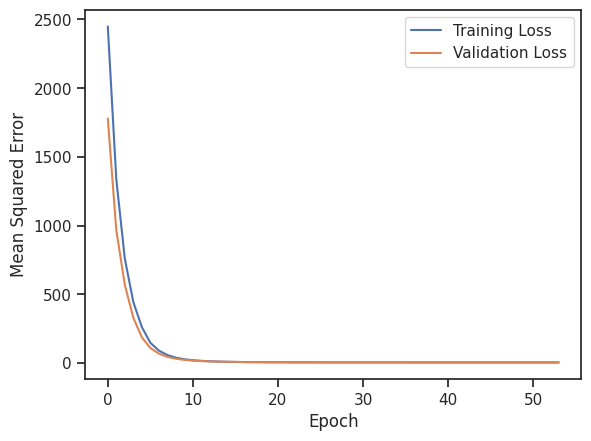

In [34]:
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

plt.plot(loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

#Métricas

Obtenemos las métricas del modelo sobre los datos de testeo.


In [35]:
def print_metrics_table(model, X_test: pd.Series, y_test: pd.Series):
  """
  Imprime una tabla en terminal con métricas de evaluación para un modelo de
  regresión como MAE, MSE, RMSE, R2, MAPE y R2 ajustado, para el modelo dado
  y los datos de prueba proporcionados.

  Parámetros:
  model (DecisionTreeRegressor): El modelo de regresión entrenado.
  X_test (pandas.Series): Conjunto de datos de características de prueba.
  y_test (pandas.Series): Valores reales correspondientes a las
  características de prueba.
  """

  predictions = model.predict(X_test).flatten()

  # Calcular las métricas
  y_test = y_test.astype(float)
  mae = mean_absolute_error(y_test, predictions)
  mse = mean_squared_error(y_test, predictions)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_test, predictions)
  mape = np.mean(np.abs((y_test - predictions) / y_test) * 100)
  n = len(y_test)
  p = X_test.shape[1]
  r2_adjusted = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

  # Crear una tabla
  table = PrettyTable()
  table.field_names = ["Métrica", "Valor"]
  table.add_row(["Error Absoluto Medio (MAE)", round(mae, 5)])
  table.add_row(["Error Cuadrático Medio (MSE)", round(mse, 5)])
  table.add_row(["Raíz del Error Cuadrático Medio (RMSE)", round(rmse, 5)])
  table.add_row(["Error Porcentual Absoluto Medio (MAPE)", round(mape, 5)])
  table.add_row(["R-cuadrado (R2)", round(r2, 5)])
  table.add_row(["R-cuadrado ajustado (R2 ajustado)", round(r2_adjusted, 5)])

  # Mostrar la tabla en la terminal
  print(table)

In [36]:
print_metrics_table(model, X_test_scaled, y_test)

63/63 [==============================] - 0s 1ms/step
+----------------------------------------+---------+
|                Métrica                 |  Valor  |
+----------------------------------------+---------+
|       Error Absoluto Medio (MAE)       | 1.62801 |
|      Error Cuadrático Medio (MSE)      | 4.19388 |
| Raíz del Error Cuadrático Medio (RMSE) |  2.0479 |
| Error Porcentual Absoluto Medio (MAPE) | 3.55396 |
|            R-cuadrado (R2)             | 0.98868 |
|   R-cuadrado ajustado (R2 ajustado)    | 0.98865 |
+----------------------------------------+---------+


Las métricas obtenidas revelan que el desempeño del modelo es muy bueno.

El Error Absoluto Medio (MAE) de 1.62506 indica que las predicciones en promedio se desvían por aproximadamente 1.63 unidades del valor real.

El Error Porcentual Absoluto Medio (MAPE) de 3.52994% representa un error absoluto del 3.53% en comparación con los valores reales.

El R2 de 0.98885 y el R-cuadrado ajustado de 0.98882 indican que el modelo explica casi el 98.885% de la variabilidad de los datos, lo que sugiere un ajuste muy bueno del modelo.


# Visualización

## Tabla de datos

Creamos una funcion que nos permita ver los valores que ingresan en la red, la performance predicha y real y el error en la prediccion.

In [41]:
def print_prediction_table(model, X_test, y_test, columns, tamanio=20):
  y_test.reset_index(drop=True, inplace=True)

  predictions = model.predict(X_test).flatten()

  errors = abs(predictions - y_test)

  table = PrettyTable()

  column_names = columns + ["Valor Real", "Valor Predicho", "Error"]
  table.field_names = column_names

  for i in range(tamanio):
    row_values = list(X_test.iloc[i]) + [y_test.iloc[i], round(predictions[i], 2), round(errors[i], 2)]
    table.add_row(row_values)

  print(table)


In [42]:
columns = X.columns.tolist()
print_prediction_table(model, X_test, y_test, columns)

63/63 [==============================] - 0s 2ms/step
+---------------+-----------------+----------------------------+-------------+----------------------------------+------------+----------------+-------+
| Hours Studied | Previous Scores | Extracurricular Activities | Sleep Hours | Sample Question Papers Practiced | Valor Real | Valor Predicho | Error |
+---------------+-----------------+----------------------------+-------------+----------------------------------+------------+----------------+-------+
|       5       |        69       |             0              |      8      |                2                 |    51.0    |     96.91      | 45.91 |
|       2       |        46       |             1              |      4      |                8                 |    20.0    |     96.91      | 76.91 |
|       7       |        56       |             1              |      7      |                5                 |    46.0    |     96.91      | 50.91 |
|       6       |        42       |

Podemos ver en la tabla los errores en las 20 primeras predicciones de los datos de test y se observa que el error oscila entre 6 y -6 puntos de diferencia.

## Grafico de disperción

Creamos una funcion que permita mostrar la disperción de los datos predichos y los datos reales para ver su comportamiento según cada variable.

In [68]:
def plot_prediction_vs_actual(model, X_test, y_test, columns):
  # Obtener las predicciones del modelo
  predictions = model.predict(X_test).flatten()

  # Crear una figura con subplots para cada columna
  num_columns = len(columns)
  fig, axes = plt.subplots(nrows=num_columns, ncols=1, figsize=(10, 5*num_columns))

  # Iterar sobre las columnas y graficar los puntos
  for i, column in enumerate(columns):
    # Graficar los puntos reales vs predichos
    ax = axes[i]
    ax.scatter(X_test[:, i], y_test, color='blue', label='Real')
    ax.scatter(X_test[:, i], predictions, color='red', label='Predicho')
    ax.set_xlabel(column)
    ax.set_ylabel('Performance')
    ax.legend()
    ax.set_title(f'Valores Reales vs Predichos para la columna {column}')

  plt.tight_layout()
  plt.show()


63/63 [==============================] - 0s 1ms/step


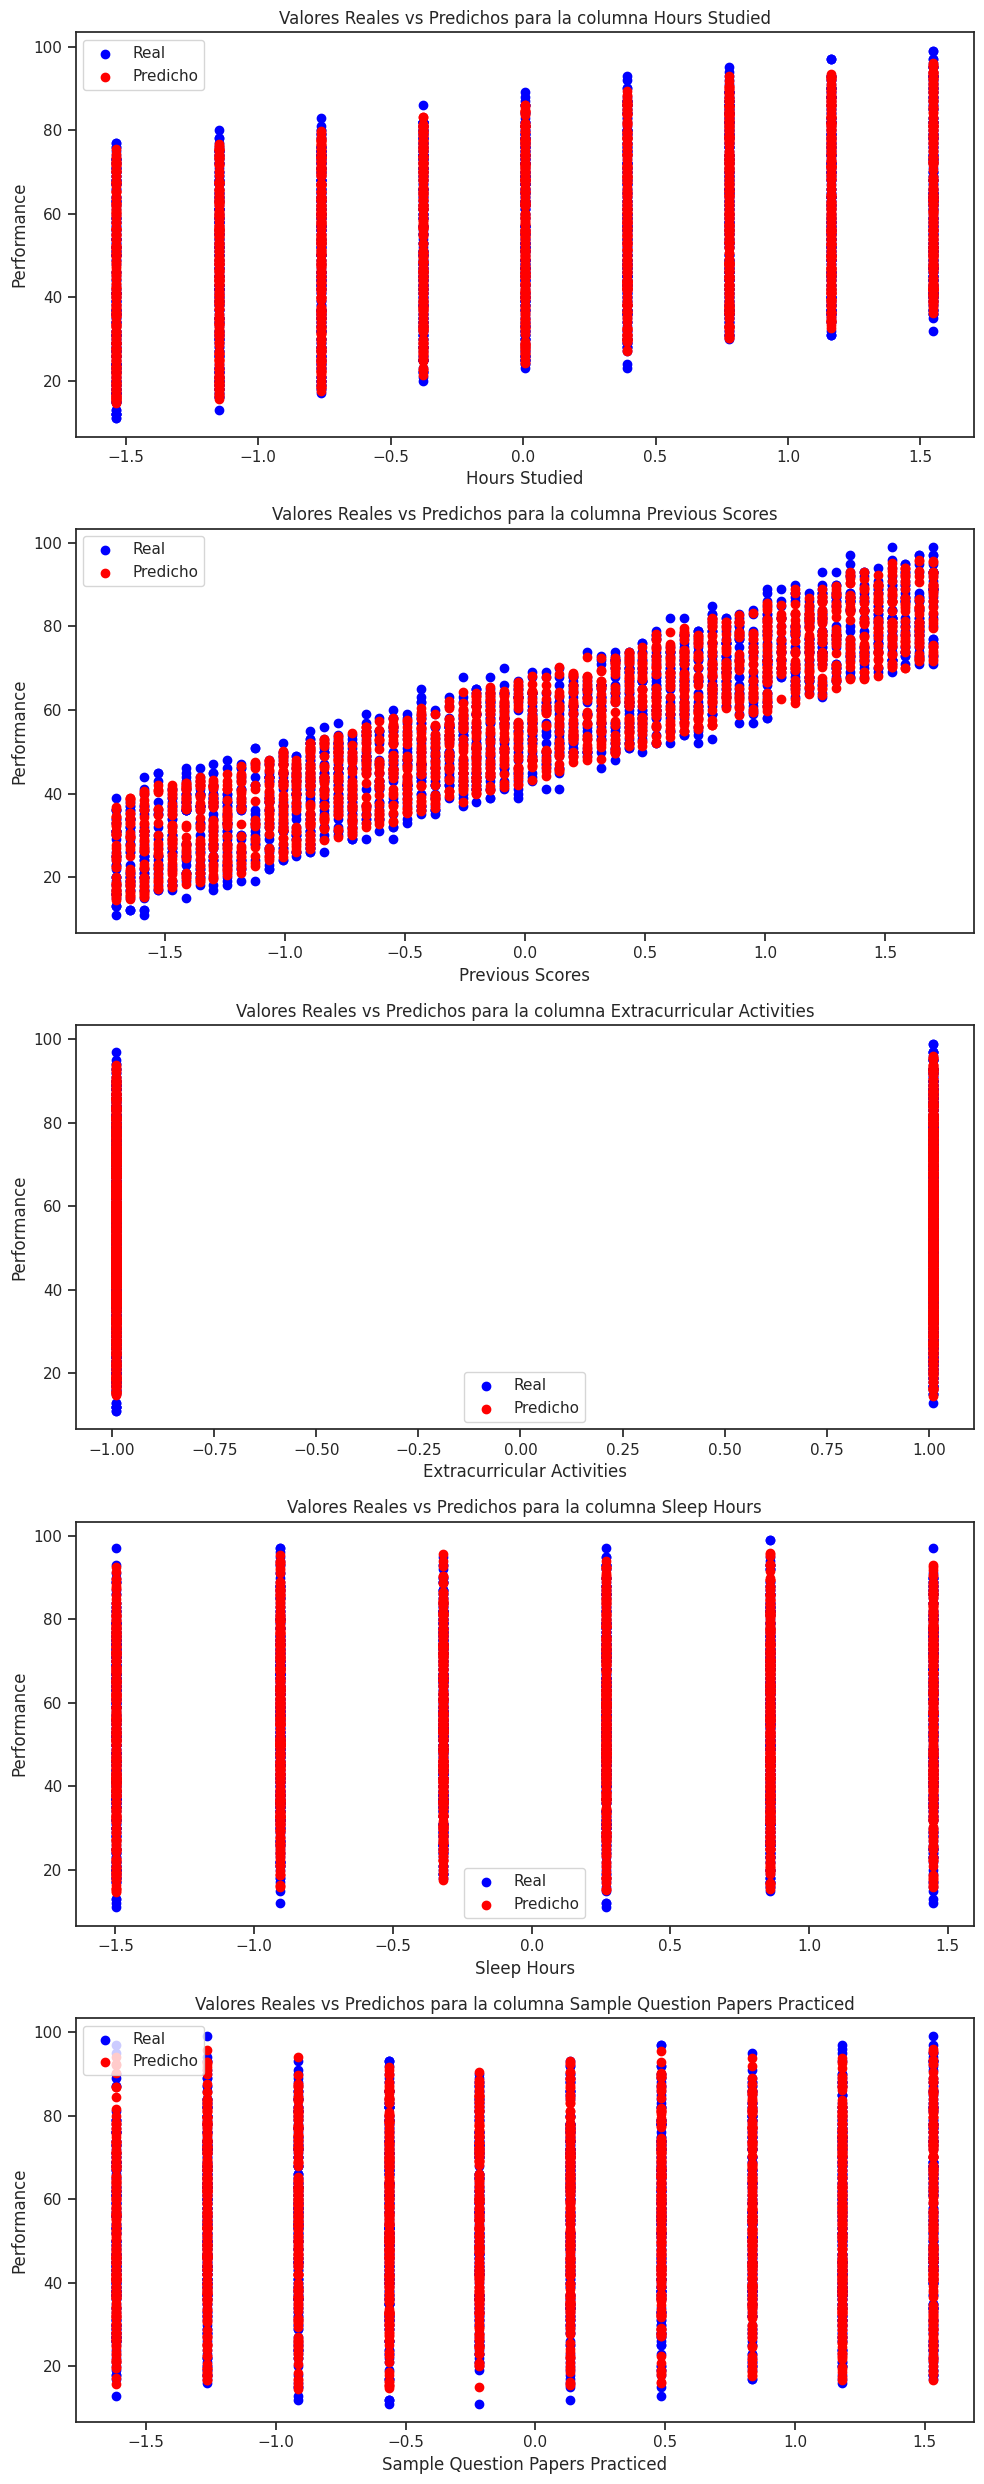

In [69]:
plot_prediction_vs_actual(model, X_test_scaled, y_test, columns)

Observamos que los valores predichos y los valores reales de la Performance de cada estudiante están superpuestos concluyendo que, a ecepcion de datos anomalos, el modelo predice correctamente el comportamiento de los valores.

A su vez observamos que las variables más coorelacionadas con 'Performance index' son 'Hours studie' y 'Previous Score'.